<img src="notmnist.png">

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [1]:
import os
import time
import urllib.request
import hashlib
import zipfile
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import pdb

In [4]:
with tf.Session() as sess:
    devs = sess.list_devices()
    print('\n'.join([x.name for x in devs]))

/job:localhost/replica:0/task:0/device:CPU:0


# Read Data

### Download

In [11]:
def download(url, file, md5sum):
    if not os.path.isfile(file):
        print('Downloading', file, '...')
        urllib.request.urlretrieve(url, file)
        assert hashlib.md5(open(file, 'rb').read()).hexdigest() == md5sum
    
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip',
        'notMNIST_train.zip', 'c8673b3f28f489e9cdf3a3d74e2ac8fa')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip',
        'notMNIST_test.zip', '5d3c7e653e63471c88df796156a9dfa9')


In [72]:
def uncompress(file):
    x_vec, y_vec = [], []    
    with zipfile.ZipFile(file) as zipf:
        filenames = zipf.namelist()
        for file in filenames:
            if not file.endswith('/'):
                with zipf.open(file) as img:
                    image = PIL.Image.open(img)
                    image.load()
                    x_vec.append( np.array(image, dtype=np.float32) )
                    y_vec.append( os.path.split(file)[1][0] )
    return np.array(x_vec), np.array(y_vec)

# [np.ndarray(28x28)] [str]
train_x_raw, train_y_raw = uncompress('notMNIST_train.zip')
test_x_raw, test_y_raw = uncompress('notMNIST_test.zip')
N_train = len(train_x_raw)
N_test = len(test_x_raw)

### Pre-process

Scale

In [194]:
def normalize(data):
    imin, imax = 0, 255
    omin, omax = 0.1, 0.9
    data_01 = data / imax
    return data_01*(omax-omin) + omin

train_x = normalize(train_x_raw).reshape([N_train, 28*28])
test_x = normalize(test_x_raw).reshape([N_test, 28*28])

One-hot

In [195]:
def onehot(data):
    N = len(data)
    data_0123 = data.view(np.int32) - ord('A')    # [1, 2, ...]
    onehot = np.zeros([N, 10])        # [[0, 0, 0], [0, 0, 0], ...]
    onehot[range(N), data_0123] = 1   # [[0, 1, 0], [0, 0, 1], ...]
    return onehot
train_y = onehot(train_y_raw)
test_y = onehot(test_y_raw)

Split

In [196]:
np.random.seed(0)

indices = np.array(range(N_train))
np.random.shuffle(indices)
train_i, valid_i = np.split(indices, [int(0.95*N_train)])

valid_x = train_x[valid_i]
valid_y = train_y[valid_i]

train_x = train_x[train_i]
train_y = train_y[train_i]

In [197]:
len(train_x)

199500

### Checkpoint - Save

In [ ]:
raise  # sentinel
with open('notMNIST.pickle', 'wb') as pfile:
    pickle_dict = {'train_x': train_x, 'train_y': train_y,
                   'valid_x': valid_x, 'valid_y': valid_y,
                   'test_x': test_x, 'test_y': test_y }
    pickle.dump(pickle_dict, pfile)

### Checkpoint - Load

In [2]:
with open('notMNIST.pickle', 'rb') as pfile:
    pickle_dict = pickle.load(pfile)
    train_x = pickle_dict['train_x']
    train_y = pickle_dict['train_y']
    valid_x = pickle_dict['valid_x']
    valid_y = pickle_dict['valid_y']
    test_x = pickle_dict['test_x']
    test_y = pickle_dict['test_y']
    del pickle_dict  # free up memory

# Explore Data

In [4]:
len(train_x)

199500

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


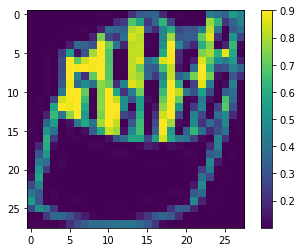

In [5]:
idx = 70004
plt.imshow(train_x[idx].reshape([28, 28]))
plt.colorbar()
print(train_y[idx])

# Model

Create Model - Simple

In [3]:
N_in = 28*28
N_out = 10

tf.reset_default_graph()

xi = tf.placeholder(dtype=tf.float32, shape=[None, N_in])
yi = tf.placeholder(dtype=tf.float32, shape=[None, N_out])
tr = tf.placeholder(dtype=tf.bool, shape=[])  # disconnected, used in advanced example

W = tf.get_variable('W', shape=[N_in, N_out], dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(
                        mean=0.0, stddev=N_in**-0.5))
biases = tf.get_variable('bias', shape=[1, N_out], dtype=tf.float32,
                      initializer=tf.zeros_initializer())

logits = tf.matmul(xi, W) + biases
probabilities = tf.nn.softmax(logits)
loss = tf.losses.softmax_cross_entropy(yi, logits)

# this is math-correct but computotianlly unstable !!
# results in loss being NaN sometimes/often
# probabilities = 
#     tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis=-1, keepdims=True)
# cross_entropy = -tf.reduce_sum(
#     yi * tf.log(probabilities), reduction_indices=1)
# loss = tf.reduce_mean(cross_entropy)

is_correct = tf.equal(tf.argmax(probabilities, axis=-1), tf.argmax(yi, axis=-1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

Create Model - Advanced

In [6]:
N_in = 28*28
N_hid = 100
N_out = 10
dr = 0.5

tf.reset_default_graph()

xi = tf.placeholder(dtype=tf.float32, shape=[None, N_in])
yi = tf.placeholder(dtype=tf.float32, shape=[None, N_out])
tr = tf.placeholder(dtype=tf.bool, shape=[])

W_hid = tf.get_variable('W_hid', shape=[N_in, N_hid], dtype=tf.float32,
                        initializer=tf.truncated_normal_initializer(
                            mean=0.0, stddev=N_in**-0.5))
W_out = tf.get_variable('W_out', shape=[N_hid, N_out], dtype=tf.float32,
                        initializer=tf.truncated_normal_initializer(
                            mean=0.0, stddev=N_hid**-0.5))
b_hid = tf.get_variable('b_hid', shape=[1, N_hid], dtype=tf.float32,
                      initializer=tf.zeros_initializer())
b_out = tf.get_variable('b_out', shape=[1, N_out], dtype=tf.float32,
                      initializer=tf.zeros_initializer())

q_hid = tf.matmul(xi, W_hid) + b_hid
o_hid = tf.nn.relu(q_hid)
o_hid = tf.layers.dropout(o_hid, rate=dr, training=tr)

logits = tf.matmul(o_hid, W_out) + b_out

probabilities = tf.nn.softmax(logits)
loss = tf.losses.softmax_cross_entropy(yi, logits)

# this is math-correct but computotianlly unstable !!
# results in loss being NaN sometimes/often
# probabilities = 
#     tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis=-1, keepdims=True)
# cross_entropy = -tf.reduce_sum(
#     yi * tf.log(probabilities), reduction_indices=1)
# loss = tf.reduce_mean(cross_entropy)

is_correct = tf.equal(tf.argmax(probabilities, axis=-1), tf.argmax(yi, axis=-1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

Quick test with untrained NN

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_loss, train_acc = sess.run([loss, accuracy],
                                     feed_dict={xi:train_x, yi: train_y, tr:False})
    valid_acc = sess.run(accuracy, feed_dict={xi:valid_x, yi: valid_y, tr:False})

print('train_loss', train_loss)
print('train_acc', train_acc)
print('valid_acc', valid_acc)

train_loss 2.3630016
train_acc 0.10579449
valid_acc 0.10933334


Main train loop!

In [4]:
batch_size = 128
nb_epochs = 2
lr = 0.01

optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)

log_batch_nb = []
log_loss = []
log_train_acc = []
log_valid_acc = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
        
    batch_nb = 0
    for e in range(nb_epochs):
        ts = time.time()
        for i in range(0, len(train_x), batch_size):
            xb = train_x[i:i+batch_size]
            yb = train_y[i:i+batch_size]
            
            _, ll = sess.run([optimizer, loss], feed_dict={xi: xb, yi: yb, tr:True})
            
            if batch_nb % 250 == 0:                
                train_acc = sess.run(accuracy, feed_dict={xi:train_x, yi: train_y, tr:False})
                valid_acc = sess.run(accuracy, feed_dict={xi:valid_x, yi: valid_y, tr:False})
                
                log_batch_nb.append(batch_nb)
                log_loss.append(ll)
                log_train_acc.append(train_acc)
                log_valid_acc.append(valid_acc)
                
                print('ep, bn, train_acc, valid_acc', e, batch_nb, train_acc, valid_acc)
                
            batch_nb += 1
        print('Ep time:', time.time() - ts)
            
    test_acc = sess.run(accuracy, feed_dict={xi:test_x, yi: test_y, tr:False})
    print('Test accuracy:', test_acc)
    


ep, bn, train_acc, valid_acc 0 0 0.07695238 0.078857146
ep, bn, train_acc, valid_acc 0 250 0.7785163 0.77047616
ep, bn, train_acc, valid_acc 0 500 0.79259145 0.78485715
ep, bn, train_acc, valid_acc 0 750 0.7982105 0.7927619
ep, bn, train_acc, valid_acc 0 1000 0.8028772 0.7985714
ep, bn, train_acc, valid_acc 0 1250 0.80660653 0.8029524
ep, bn, train_acc, valid_acc 0 1500 0.81038594 0.80866665
Ep time: 6.9257543087005615
ep, bn, train_acc, valid_acc 1 1750 0.8122807 0.8082857
ep, bn, train_acc, valid_acc 1 2000 0.8142005 0.8108571
ep, bn, train_acc, valid_acc 1 2250 0.81557894 0.8112381
ep, bn, train_acc, valid_acc 1 2500 0.81599 0.81304765
ep, bn, train_acc, valid_acc 1 2750 0.81769425 0.81390476
ep, bn, train_acc, valid_acc 1 3000 0.8180852 0.8152381
Ep time: 6.121492147445679
Test accuracy: 0.8858


Plot plot

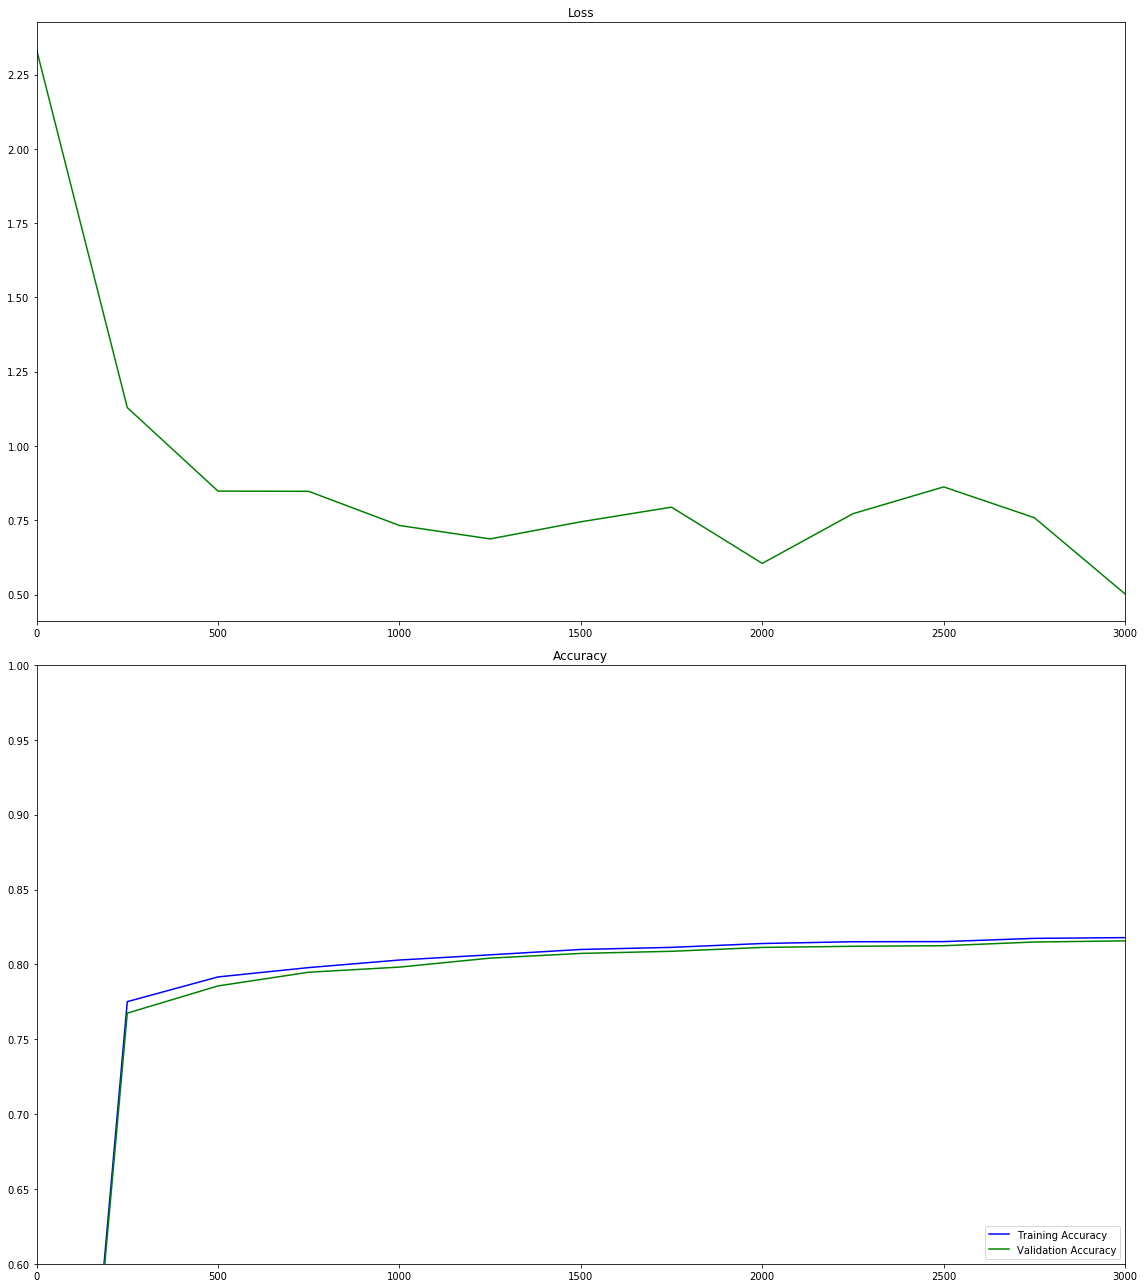

In [9]:
fig = plt.figure(figsize=[16,18])

ax_loss = fig.add_subplot(211)
ax_loss.set_title('Loss')
ax_loss.plot(log_batch_nb, log_loss, 'g')
ax_loss.set_xlim([log_batch_nb[0], log_batch_nb[-1]])

ax_acc = plt.subplot(212)
ax_acc.set_title('Accuracy')
ax_acc.plot(log_batch_nb, log_train_acc, color='blue', label='Training Accuracy')
ax_acc.plot(log_batch_nb, log_valid_acc, color='green', label='Validation Accuracy')
ax_acc.set_ylim([0.6, 1.0])
ax_acc.set_xlim([log_batch_nb[0], log_batch_nb[-1]])
ax_acc.legend(loc=4)

plt.tight_layout()
plt.show()